In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from fbprophet import Prophet




import time as time
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics


ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
df_hist_pagos= pd.read_excel("C:/Renato/Centro Movil/poc.xlsx"
,sheet_name="HISTORIAL DE PAGOS")

df_lim_cred= pd.read_excel("C:/Renato/Centro Movil/poc.xlsx"
,sheet_name="LÍMITE DE CRÉDITO")




df_hist_pagos['FECHA DE FACTURA'] = pd.to_datetime(df_hist_pagos['FECHA DE FACTURA'])
df_hist_pagos['FECHA DE PAGO'] = pd.to_datetime(df_hist_pagos['FECHA DE PAGO'])
df_hist_pagos['PAGO_TARDIO'] = (df_hist_pagos['FECHA DE PAGO'] > df_hist_pagos['FECHA DE VENCIMIENTO']).astype(int)
# Calcular la diferencia entre la fecha de vencimiento y la fecha de factura
df_hist_pagos['TIEMPO_MAXIMO'] = (df_hist_pagos['FECHA DE VENCIMIENTO'] - df_hist_pagos['FECHA DE FACTURA']).dt.days

# Calcular la diferencia entre la fecha de pago y la fecha de factura
df_hist_pagos['TIEMPO_REAL'] = (df_hist_pagos['FECHA DE PAGO'] - df_hist_pagos['FECHA DE FACTURA']).dt.days

# Calcular el porcentaje de tiempo real en relación con el tiempo máximo permitido
df_hist_pagos['PORCENTAJE_DEMORA'] = df_hist_pagos['TIEMPO_REAL'] / df_hist_pagos['TIEMPO_MAXIMO'].where(df_hist_pagos['TIEMPO_MAXIMO'] != 0, 1)


# Agregar columnas de mes y año para facilitar el agrupamiento
df_hist_pagos['MES'] = df_hist_pagos['FECHA DE FACTURA'].dt.month
df_hist_pagos['AÑO'] = df_hist_pagos['FECHA DE FACTURA'].dt.year

df_hist_pagos = df_hist_pagos[(df_hist_pagos['MONTO PAGADO'] >= 1) & 
                              (df_hist_pagos['FECHA DE FACTURA'] <= df_hist_pagos['FECHA DE PAGO']) &
                               (df_hist_pagos['FECHA DE FACTURA'] <= df_hist_pagos['FECHA DE VENCIMIENTO']) ]

# Encuentra la fecha más reciente para cada clientes
last_purchase_dates = df_hist_pagos.groupby('COD. CLIENTE')['FECHA DE FACTURA'].max().reset_index()

# Calcula la fecha tres meses antes de la última compra para cada cliente
last_purchase_dates['FECHA_INICIO'] = last_purchase_dates['FECHA DE FACTURA'] - pd.DateOffset(months=3)

# Combina este DataFrame con el original para filtrar los datos
df_hist_pagos_3_moths = pd.merge(df_hist_pagos, last_purchase_dates[['COD. CLIENTE', 'FECHA_INICIO']], on='COD. CLIENTE', how='left')
df_hist_pagos_3_moths = df_hist_pagos_3_moths[df_hist_pagos_3_moths['FECHA DE FACTURA'] >= df_hist_pagos_3_moths['FECHA_INICIO']]

print(df_hist_pagos)
print(df_hist_pagos_3_moths)

# Agrupar por cliente, mes y año, calcular el promedio del monto pagado y el conteo de facturas. 
# LUEGO RENOMBRAR
grouped_data = df_hist_pagos_3_moths.groupby(['COD. CLIENTE','CLIENTE', 'AÑO', 'MES','FECHA_INICIO']).agg({'MONTO PAGADO': 'mean', 'NRO. DE FACTURA': 'count',
                                                                                    'PAGO_TARDIO':'sum','PORCENTAJE_DEMORA':'mean'}).reset_index()
grouped_data = grouped_data.rename(columns={'MONTO PAGADO': 'PROMEDIO MONTO PAGADO', 'NRO. DE FACTURA': 'FACTURAS PROMEDIO',
                                            'PAGO_TARDIO':'SUMA PAGO TARDIOS','PORCENTAJE_DEMORA':'PROMEDIO PORCENTAJE DEMORA'})

#Agrupar por cliente, calcular el promedio de montos pagado totales, facturas promedios por mes, sumas de pagos tardios y ratio promedio de porcentaje de demora total
grouped_data_2 = grouped_data.groupby(['COD. CLIENTE','CLIENTE','FECHA_INICIO']).agg({'PROMEDIO MONTO PAGADO': 'mean', 'FACTURAS PROMEDIO': 'mean','SUMA PAGO TARDIOS':'mean'}).reset_index()
grouped_data_2 = grouped_data_2.rename(columns={'PROMEDIO MONTO PAGADO': 'PROMEDIO MONTO PAGADO POR MES', 'FACTURAS PROMEDIO': 'FACTURAS PROMEDIO POR MES',
                                                'SUMA PAGO TARDIOS':'PROMEDIO SUMA PAGO TARDIOS',})


# Mostrar el resultado final

df_lim_cred= df_lim_cred[df_lim_cred['LÍMITE DE CRÉDITO USD'] > 100]
grouped_data_3  = pd.merge(grouped_data_2, df_lim_cred, on='COD. CLIENTE', how='left')




#Se sacab 
sum_facturas = df_hist_pagos_3_moths.groupby(['COD. CLIENTE']).agg({'NRO. DE FACTURA': 'count','PAGO_TARDIO':'sum','PORCENTAJE_DEMORA':'mean'}).reset_index()
sum_facturas = sum_facturas.rename(columns={ 'NRO. DE FACTURA': 'CANTIDAD TOTAL FACTURAS','PAGO_TARDIO':'CANTIDAD TOTAL PAGO TARDIO','PORCENTAJE_DEMORA':'PROMEDIO TOTAL PORCENTAJE DEMORA'})
sum_facturas['PORCENTAJE_PAGOS_TARDIOS'] = sum_facturas['CANTIDAD TOTAL PAGO TARDIO'] / sum_facturas['CANTIDAD TOTAL FACTURAS']




grouped_data_4  = pd.merge(grouped_data_3, sum_facturas, on='COD. CLIENTE', how='left')



df_hist_pagos_3_moths.to_excel("C:/Renato/Centro Movil/Input_filtrado.xlsx"
,sheet_name="Hoja1")

#grouped_data_4.to_excel("C:/Renato/Centro Movil/Output_por_cliente_3meses.xlsx",sheet_name="Hoja1")
#print(grouped_data_4.columns)



       COD. CLIENTE                               CLIENTE FECHA DE FACTURA  \
0                52                             WOLS BRAS       2022-04-11   
1               236            SISTEMAS ELECTRICOS MATIAS       2022-04-11   
3               458                           ASIA MOTORS       2022-04-11   
4               877                         PERNOS CHOQUE       2022-04-11   
5               877                         PERNOS CHOQUE       2022-04-11   
...             ...                                   ...              ...   
52060          2525  AUTOREPUESTOS AGUIRRE SATELITE NORTE       2023-10-31   
52061          2525  AUTOREPUESTOS AGUIRRE SATELITE NORTE       2023-10-31   
52062          2525  AUTOREPUESTOS AGUIRRE SATELITE NORTE       2023-10-31   
52063          2527                        DANNY ELECTRIC       2023-10-31   
52064          2527                        DANNY ELECTRIC       2023-10-31   

      FECHA DE VENCIMIENTO FECHA DE PAGO  MONTO PAGADO  NRO. DE

C:\Users\Renato\AppData\Local\Temp\ipykernel_20032\3820183499.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



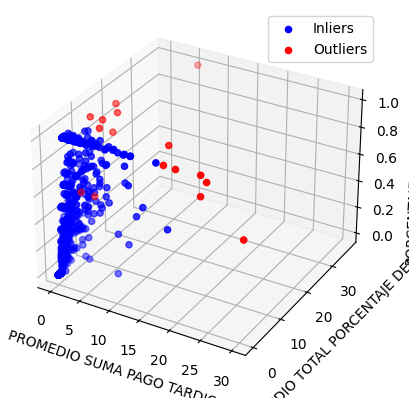

In [ ]:

index_original = grouped_data_4.index

X= grouped_data_4[[#'COD. CLIENTE',
    # 'CLIENTE', 
    # 'FECHA_INICIO',
    #   'PROMEDIO MONTO PAGADO POR MES',
    #  'FACTURAS PROMEDIO POR MES',
       'PROMEDIO SUMA PAGO TARDIOS', 
       #'LÍMITE DE CRÉDITO USD',
       #'CANTIDAD TOTAL FACTURAS',
       #  'CANTIDAD TOTAL PAGO TARDIO',
       'PROMEDIO TOTAL PORCENTAJE DEMORA', 'PORCENTAJE_PAGOS_TARDIOS']]

model =  IsolationForest(contamination=float(.01))
model.fit(X)
X['anomaly'] = model.predict(X)
index_not_outliers = X[X['anomaly'] != -1].index


column_names = ['PROMEDIO SUMA PAGO TARDIOS', 'PROMEDIO TOTAL PORCENTAJE DEMORA', 'PORCENTAJE_PAGOS_TARDIOS']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Separar los datos en outliers y no outliers
outliers = X[X['anomaly'] == -1]
inliers = X[X['anomaly'] == 1]

# Graficar inliers y outliers
ax.scatter(inliers[column_names[0]], inliers[column_names[1]], inliers[column_names[2]], c='blue', label='Inliers')
ax.scatter(outliers[column_names[0]], outliers[column_names[1]], outliers[column_names[2]], c='red', label='Outliers')

# Etiquetas de los ejes
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# Mostrar leyenda
plt.legend()

plt.show()


In [ ]:
X= X[X['anomaly'] != -1]
X= X.drop(columns=['anomaly'])

scaler = MinMaxScaler()  # Inicializar el escalador
X_esc = scaler.fit_transform(X)
X_esc = pd.DataFrame(data=X_esc, columns=X.columns) 
print(X_esc)


      PROMEDIO SUMA PAGO TARDIOS  PROMEDIO TOTAL PORCENTAJE DEMORA  \
0                       0.000000                          0.020819   
1                       0.000000                          0.148508   
2                       0.027778                          0.168051   
3                       0.074074                          0.076114   
4                       0.222222                          0.144285   
...                          ...                               ...   
1502                    0.000000                          0.053326   
1503                    0.000000                          0.014141   
1504                    0.000000                          0.008766   
1505                    0.000000                          0.021915   
1506                    0.000000                          0.000000   

      PORCENTAJE_PAGOS_TARDIOS  
0                     0.000000  
1                     0.000000  
2                     0.333333  
3                     0.190

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

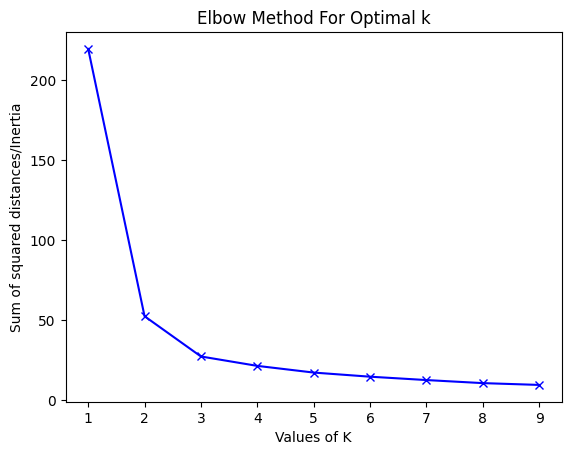

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

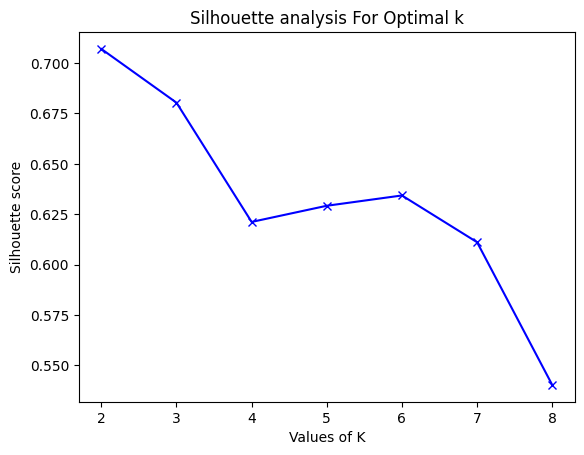

Compute unstructured hierarchical clustering...


In [ ]:



Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_esc)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_esc)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(metrics.silhouette_score(X_esc, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()
print("Compute unstructured hierarchical clustering...")



Elapsed time: 0.01s
Number of points: 1507


c:\Users\Renato\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



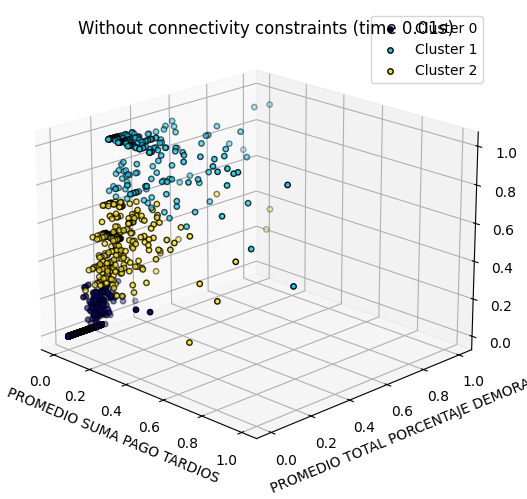

In [ ]:

st = time.time()
ward = KMeans(n_clusters=3).fit(X_esc)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")
column_names = ['PROMEDIO SUMA PAGO TARDIOS', 'PROMEDIO TOTAL PORCENTAJE DEMORA', 'PORCENTAJE_PAGOS_TARDIOS']

plt.rcParams['interactive'] == True
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=20, azim=-45)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X_esc.loc[label == l, 'PROMEDIO SUMA PAGO TARDIOS'],
        X_esc.loc[label == l, 'PROMEDIO TOTAL PORCENTAJE DEMORA'],
        X_esc.loc[label == l, 'PORCENTAJE_PAGOS_TARDIOS'],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=15,
        edgecolor="k",
        label=f'Cluster {l}'  # Add labels for clusters
    )
ax1.set_xlabel(column_names[0])
ax1.set_ylabel(column_names[1])
ax1.set_zlabel(column_names[2])
_ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")
plt.legend()

# Show the 3D plot
plt.show()

In [ ]:
import plotly.express as px

# Assuming X_esc is a DataFrame
fig = px.scatter_3d(
    X_esc,
    x='PROMEDIO SUMA PAGO TARDIOS',
    y='PROMEDIO TOTAL PORCENTAJE DEMORA',
    z='PORCENTAJE_PAGOS_TARDIOS',
    color=label.astype(str),  # Converting labels to string for color separation
    labels={'PROMEDIO SUMA PAGO TARDIOS': 'PROMEDIO SUMA PAGO TARDIOS', 
            'PROMEDIO TOTAL PORCENTAJE DEMORA': 'PROMEDIO TOTAL PORCENTAJE DEMORA',
            'PORCENTAJE_PAGOS_TARDIOS': 'PORCENTAJE_PAGOS_TARDIOS'},
    title=f"Without connectivity constraints (time {elapsed_time:.2f}s)",
    opacity=0.7, 
)
fig.show()

In [ ]:

# DataFrame original 
grouped_data_4['cluster'] = -1

grouped_data_4.loc[index_not_outliers, 'cluster'] = label




In [ ]:
grouped_data_4.to_excel("C:/Renato/Centro Movil/Output_por_cliente_3meses.xlsx",sheet_name="Hoja1")

print(grouped_data_4.columns)

Index(['COD. CLIENTE', 'CLIENTE', 'FECHA_INICIO',
       'PROMEDIO MONTO PAGADO POR MES', 'FACTURAS PROMEDIO POR MES',
       'PROMEDIO SUMA PAGO TARDIOS', 'LÍMITE DE CRÉDITO USD',
       'CANTIDAD TOTAL FACTURAS', 'CANTIDAD TOTAL PAGO TARDIO',
       'PROMEDIO TOTAL PORCENTAJE DEMORA', 'PORCENTAJE_PAGOS_TARDIOS',
       'cluster'],
      dtype='object')


In [ ]:
# Agrupar por cliente, mes y año, calcular la suma de pagos tardíos y la suma de facturas.
grouped_payments = df_hist_pagos.groupby(['COD. CLIENTE','AÑO','MES' ]) \
    .agg({'PAGO_TARDIO': 'sum', 'NRO. DE FACTURA': 'count'}) \
    .reset_index()

# Renombrar las columnas para mayor claridad
grouped_payments = grouped_payments.rename(columns={'PAGO_TARDIO': 'SUMA PAGO TARDIOS', 'NRO. DE FACTURA': 'SUMA FACTURAS'})

# Calcular el porcentaje de pagos tardíos
grouped_payments['PORCENTAJE_PAGOS_TARDIOS'] = grouped_payments['SUMA PAGO TARDIOS'] / grouped_payments['SUMA FACTURAS']


# Contar el número total de filas por cliente (todas las combinaciones de cliente, año y mes)
rows_count = grouped_payments.groupby('COD. CLIENTE').size()

# Filtrar aquellos clientes con igual o más de 12 meses de filas
clients_with_12_months = rows_count[rows_count >= 12].index

# Mantener solo los datos de clientes con al menos 12 meses de filas
filtered_grouped_payments = grouped_payments[grouped_payments['COD. CLIENTE'].isin(clients_with_12_months)]

In [ ]:
print(len(rows_count))
print(len(filtered_grouped_payments["COD. CLIENTE"].unique()))

1517
304


In [ ]:
# Bucle para aplicar Prophet a cada cliente
for client_id in filtered_grouped_payments['COD. CLIENTE'].unique():
    # Filtrar datos del cliente específico
    client_data = filtered_grouped_payments[filtered_grouped_payments['COD. CLIENTE'] == client_id]
    
    # Renombrar las columnas requeridas por Prophet
    client_data = client_data.rename(columns={'FECHA DE FACTURA': 'ds', 'PORCENTAJE_PAGOS_TARDIOS': 'y'})
    
    # Crear y ajustar el modelo de Prophet
    model = Prophet()
    model.fit(client_data)
    
    # Generar un DataFrame con fechas futuras para pronosticar el siguiente mes
    future = model.make_future_dataframe(periods=1, freq='M')
    
    # Pronosticar el siguiente mes
    forecast = model.predict(future)
    
    # Obtener el pronóstico del siguiente mes
    next_month_forecast = forecast[['ds', 'yhat']].iloc[-1]
    
    # Imprimir el pronóstico del siguiente mes para el cliente actual
    print(f"Cliente: {client_id}, Pronóstico siguiente mes: {next_month_forecast['yhat']}")
    # Aquí podrías guardar o utilizar este pronóstico según tu necesidad